### Modelagem e Previsão de Custos Médicos: Regressão Não Linear Múltipla com Dummies para Análise de Variáveis Qualitativas e Quantitativas

Neste projeto de Data Science, meu objetivo é entender e prever os custos médicos das pessoas com base em algumas variáveis. Tenho dados de 200 pessoas que passaram por consultas ou procedimentos médicos, e quero descobrir quanto elas gastaram com despesas médicas. Para isso, vou analisar várias coisas: a idade das pessoas, quantas doenças crônicas elas têm, a renda delas e o plano de saúde que possuem. Usarei uma técnica chamada regressão não linear múltipla, que me ajudará a encontrar relações complexas entre essas variáveis e os gastos médicos. Além disso, utilizarei "dummies", que são uma forma de incluir variáveis qualitativas, como o tipo de plano de saúde, na minha análise. No final, espero obter insights valiosos que me ajudem a entender melhor esses gastos e até prever quanto uma pessoa pode gastar, dependendo das suas características.

In [4]:
# Instalação dos pacotes

# !pip install pandas
# !pip install numpy
# !pip install -U seaborn
# !pip install matplotlib
# !pip install plotly
# !pip install scipy
# !pip install statsmodels
# !pip install scikit-learn
# !pip install pingouin
# !pip install statstests

In [7]:
# Importação dos pacotes

import pandas as pd # manipulação de dados em formato de dataframe
import numpy as np # operações matemáticas
import seaborn as sns # visualização gráfica
import matplotlib.pyplot as plt # visualização gráfica
import plotly.graph_objects as go # gráficos 3D
from scipy.stats import pearsonr # correlações de Pearson
import statsmodels.api as sm # estimação de modelos
from statsmodels.iolib.summary2 import summary_col # comparação entre modelos
from sklearn.preprocessing import LabelEncoder # transformação de dados
import pingouin as pg # outro modo para obtenção de matrizes de correlações
from statstests.process import stepwise # procedimento Stepwise
from statstests.tests import shapiro_francia # teste de Shapiro-Francia
from scipy.stats import boxcox # transformação de Box-Cox
from scipy.stats import norm # para plotagem da curva normal
from scipy import stats # utilizado na definição da função 'breusch_pagan_test'

In [8]:
# Carregando a base de dados
df_planosaude = pd.read_csv('planosaude.csv', delimiter=',')
df_planosaude

,id,despmed,idade,dcron,renda,plano
0,1,206.84,57,5,57.2,bronze
1,2,184.19,67,4,67.2,bronze
2,3,175.68,62,4,62.0,bronze
3,4,180.04,67,5,67.2,bronze
4,5,218.86,68,5,68.0,bronze
...,...,...,...,...,...,...
195,196,159.02,63,3,63.2,esmeralda
196,197,205.35,64,4,64.0,bronze
197,198,133.64,49,4,48.8,esmeralda
198,199,158.73,44,2,44.0,esmeralda


In [9]:
# Características das variáveis do dataset
df_planosaude.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 6 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       200 non-null    int64  
 1   despmed  200 non-null    float64
 2   idade    200 non-null    int64  
 3   dcron    200 non-null    int64  
 4   renda    200 non-null    float64
 5   plano    200 non-null    object 
dtypes: float64(2), int64(3), object(1)
memory usage: 9.5+ KB


In [11]:
# Estatísticas univariadas
    # ATANÇÃO!!!! NÃO FAÇA ISSSO!!!  Não vou usar o "id" então não era necessário convertê-la numa string, mas vou convertê-la só pelas boas práticas mesmo
df_planosaude['id'] = df_planosaude['id'].astype('str')

In [12]:
df_planosaude.describe()

,despmed,idade,dcron,renda
count,200.000000,200.000000,200.000000,200.000000
mean,161.183400,50.010000,2.705000,50.022000
std,42.447084,12.547794,1.670908,12.626538
min,88.730000,32.000000,0.000000,31.600000
25%,126.140000,38.000000,1.000000,38.000000
50%,155.000000,49.000000,2.000000,48.800000
75%,197.622500,63.000000,4.000000,63.200000
max,269.200000,68.000000,5.000000,68.000000


In [13]:
# Tabela de frequências absolutas da variável 'plano'
df_planosaude['plano'].value_counts().sort_index()

plano
bronze       72
esmeralda    66
ouro         62
Name: count, dtype: int64

<Figure size 2000x1000 with 0 Axes>

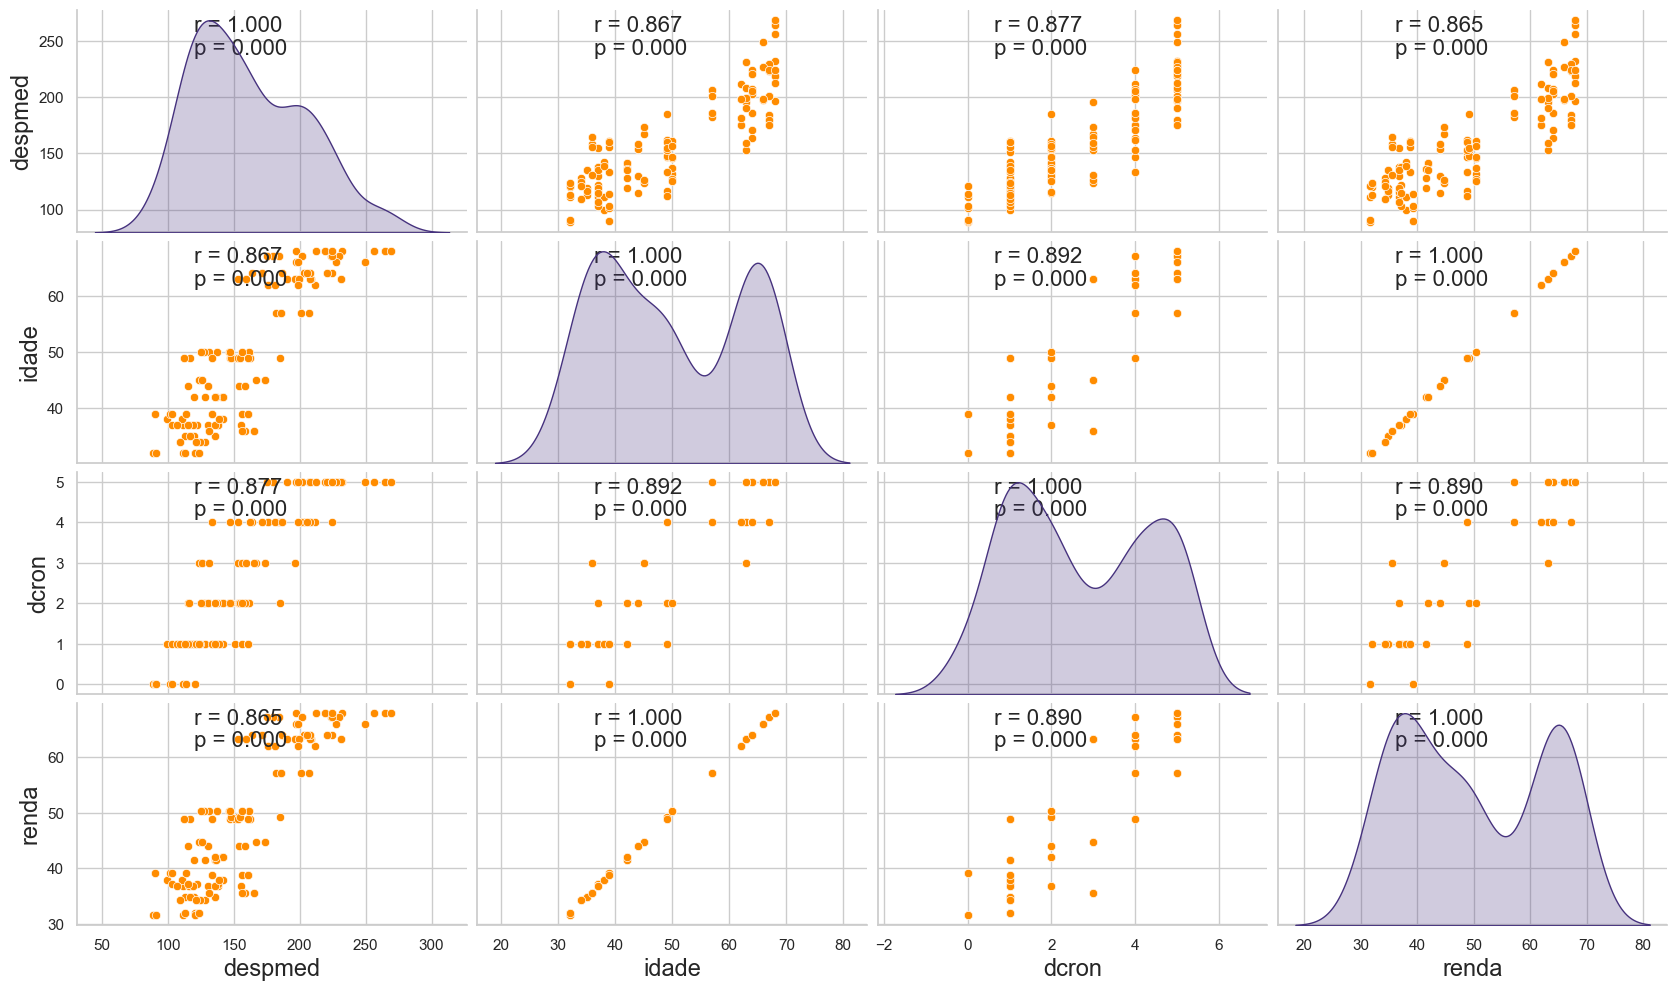

In [15]:
# Distribuições das variáveis, scatters, valores das correlações e suas respectivas significâncias

def corrfunc(x, y, **kws):
    (r, p) = pearsonr(x, y)
    ax = plt.gca()
    ax.annotate("r = {:.3f}".format(r),
                xy=(.30, .9), xycoords=ax.transAxes, fontsize=16)
    ax.annotate("p = {:.3f}".format(p),
                xy=(.30, .8), xycoords=ax.transAxes, fontsize=16)

# Configuração do gráfico
sns.set(style="whitegrid", palette="viridis")

plt.figure(figsize=(20,10))
graph = sns.pairplot(df_planosaude.loc[:,'despmed':'renda'], diag_kind="kde",
                     plot_kws={"color": "darkorange"},
                     height=2.5, aspect=1.7)
graph.map(corrfunc)
for ax in graph.axes.flat:
    ax.set_xlabel(ax.get_xlabel(), fontsize=17)
    ax.set_ylabel(ax.get_ylabel(), fontsize=17)
plt.show()

<span style="color:red;">Renda</span> e <span style="color:red;">idade</span> parecem ter correlação perfeita. Então, talvez, por um problema de multicolinearidade perfeita, uma delas pode cair fora. Ou seja, não precisamos das duas para explicar o comportamento das despesas médicas. Mas nós não sabemos ainda e é isso que vamos descobrir.


In [18]:
# Dummizando a variável 'plano' (n-1 dummies)
    # Passo 01: Dummização da variável categórica "plano", colocando "bronze" no alfa, ou seja, "bronze" como categoria de referência.
    # Para mudar a categoria de referência, basta colocar "False" no lugar de "True" em "drop_first=False"

df_planosaude_dummies = pd.get_dummies(df_planosaude, columns=['plano'],
                                       dtype=int,
                                       drop_first=True)

df_planosaude_dummies

,id,despmed,idade,dcron,renda,plano_esmeralda,plano_ouro
0,1,206.84,57,5,57.2,0,0
1,2,184.19,67,4,67.2,0,0
2,3,175.68,62,4,62.0,0,0
3,4,180.04,67,5,67.2,0,0
4,5,218.86,68,5,68.0,0,0
...,...,...,...,...,...,...,...
195,196,159.02,63,3,63.2,1,0
196,197,205.35,64,4,64.0,0,0
197,198,133.64,49,4,48.8,1,0
198,199,158.73,44,2,44.0,1,0


In [20]:
# Estimação do modelo de regressão múltipla com n-1 dummies

# Definição da fórmula utilizada no modelo
lista_colunas = list(df_planosaude_dummies.drop(columns=['id',
                                                         'despmed']).columns)


formula_dummies_modelo = ' + '.join(lista_colunas)
formula_dummies_modelo = "despmed ~ " + formula_dummies_modelo

# Estimação
modelo_planosaude = sm.OLS.from_formula(formula_dummies_modelo,
                                        df_planosaude_dummies).fit()

# Parâmetros do modelo
modelo_planosaude.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                despmed   R-squared:                       0.871
Model:                            OLS   Adj. R-squared:                  0.868
Method:                 Least Squares   F-statistic:                     262.3
Date:                Tue, 25 Feb 2025   Prob (F-statistic):           2.88e-84
Time:                        00:06:26   Log-Likelihood:                -828.04
No. Observations:                 200   AIC:                             1668.
Df Residuals:                     194   BIC:                             1688.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept         148.8595     12.744     11.681      0.000     123.725     173.994
idade               8.9227      5.549      1.608      0.109      -2.021      19.867
dcron               6.7232      1.600      4.201      0.000       3.567       9.879
renda              -8.4426      5.464     -1.545      0.124     -19.219       2.334
plano_esmeralda   -35.0189      4.685     -7.474      0.000     -44.259     -25.779
plano_ouro        -58.7653      6.075     -9.673      0.000     -70.747     -46.783
==============================================================================
Omnibus:                       25.070   Durbin-Watson:                   1.775
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               48.329
Skew:                           0.622   Prob(JB):                     3.20e-11
Kurtosis:                       5.062   Cond. No.                         964.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Pelos resultados, <span style="color:red;">Renda</span> e <span style="color:red;">idade</span> não passaram, por um problema de correlação muito alta.

In [23]:
# Procedimento Stepwise
        # PROCEDIMENTO "stepwise": O procedimento "stepwise" é um método que permite que o modelo final preditivo inclua apenas os parâmetros que sejam estatisticamente significativos.

# Autores do pacote: Luiz Paulo Fávero e Helder Prado Santos
# https://stats-tests.github.io/statstests/

from statstests.process import stepwise

# Estimação do modelo por meio do procedimento Stepwise
modelo_step_planosaude = stepwise(modelo_planosaude, pvalue_limit=0.05)

Regression type: OLS 

Estimating model...: 
 despmed ~ Q('idade') + Q('dcron') + Q('renda') + Q('plano_esmeralda') + Q('plano_ouro')

 Discarding atribute "Q('renda')" with p-value equal to 0.12394354064859592 

Estimating model...: 
 despmed ~ Q('idade') + Q('dcron') + Q('plano_esmeralda') + Q('plano_ouro')

 Discarding atribute "Q('idade')" with p-value equal to 0.1150174871613531 

Estimating model...: 
 despmed ~ Q('dcron') + Q('plano_esmeralda') + Q('plano_ouro')

 No more atributes with p-value higher than 0.05

 Atributes discarded on the process...: 

{'atribute': "Q('renda')", 'p-value': 0.12394354064859592}
{'atribute': "Q('idade')", 'p-value': 0.1150174871613531}

 Model after stepwise process...: 
 despmed ~ Q('dcron') + Q('plano_esmeralda') + Q('plano_ouro') 

                            OLS Regression Results                            
Dep. Variable:                despmed   R-squared:                       0.868
Model:                            OLS   Adj. R-squared:  

- <span style="color: red;">Idade</span> e <span style="color: red;">renda</span> não foram excluídas devido a um problema de correlação muito alta.
- Portanto, não é correto dizer que a <span style="color: red;">renda</span> não é relevante ou que a despesa médica não tem nada a ver com a <span style="color: red;">renda</span>. A variável foi excluída apenas devido a um problema de multicolinearidade Ou seja, e podemos diz é que a <span style="color: red;">renda</span> foi excluída devido a um problema de multicolinearidade e à presença de outras variáveis que provavelmente estão fazendo as vezes dela (desempenhando o mesmo papel



In [24]:
# Teste de verificação da aderência dos resíduos à normalidade

# Teste de Shapiro-Francia (n >= 30)
# Autores do pacote: Luiz Paulo Fávero e Helder Prado Santos

from statstests.tests import shapiro_francia

# Teste de Shapiro-Francia: interpretação
teste_sf = shapiro_francia(modelo_step_planosaude.resid) #criação do objeto 'teste_sf'
teste_sf = teste_sf.items() #retorna o grupo de pares de valores-chave no dicionário
method, statistics_W, statistics_z, p = teste_sf #definição dos elementos da lista (tupla)
print('Statistics W=%.5f, p-value=%.6f' % (statistics_W[1], p[1]))
alpha = 0.05 #nível de significância
if p[1] > alpha:
	print('Não se rejeita H0 - Distribuição aderente à normalidade')
else:
	print('Rejeita-se H0 - Distribuição não aderente à normalidade')


method  :  Shapiro-Francia normality test
statistics W  :  0.942916765126418
statistics z  :  4.609587272596207
p-value  :  2.0173456996167577e-06
Statistics W=0.94292, p-value=0.000002
Rejeita-se H0 - Distribuição não aderente à normalidade


In [ ]:
# Histograma dos resíduos do 'modelo_step_planosaude' com curva normal teórica para comparação das distribuições
# Kernel density estimation (KDE) - forma não-paramétrica para estimação da função densidade de probabilidade de determinada variável

from scipy.stats import norm

# Calculando os valores de ajuste da distribuição normal
(mu, sigma) = norm.fit(modelo_step_planosaude.resid)

# Gráfico propriamente dito
plt.figure(figsize=(15,10))
sns.histplot(modelo_step_planosaude.resid, bins=15, kde=True, stat="density",
             color='red', alpha=0.4)
plt.xlim(-60, 70)
x = np.linspace(-60, 70, 100)
p = norm.pdf(x, mu, sigma)
plt.plot(x, p, 'k', linewidth=2)
plt.xlabel('Resíduos do Modelo Stepwise Linear', fontsize=20)
plt.ylabel('Frequência', fontsize=20)
plt.xticks(fontsize=17)
plt.yticks(fontsize=17)
plt.show()

Pelo Gráfico, vimos que a Distribuição não aderente à normalidade pelo teste de "Shapiro-Francia". Portanto, vamos realizar o teste de Breusch-Pagan para a elaboração de diagnóstico de heterocedasticidade

Pelo Gráfico, vimos que a Distribuição não é aderente à normalidade pelo teste de <span style="color: red;">Shapiro-Francia</span>. Portanto, vamos realizar o teste de <span style="color: red;">Breusch-Pagan</span> para a elaboração de diagnóstico de <span style="color: red;">heterocedasticidade</span>.
